In [85]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
sns.set()

In [86]:
sim_metadata_fold = "../../../data/carla_sim/random_spawn/"
sim_responses_fold = "../../../data/experiments/carla_sim/random_spawn/on_off_cells/"
sim_manual_rec_fold = "../../../data/experiments/carla_sim/manual_recorded_scenes/"

samples = os.listdir(sim_metadata_fold)

In [87]:
samples

['example_571',
 'example_465',
 'example_797',
 'example_563',
 'example_372',
 'example_219',
 'example_334',
 'example_340',
 'example_584',
 'example_163',
 'example_750',
 'example_482',
 'example_213',
 'example_379',
 'example_102',
 'example_689',
 'example_520',
 'example_614',
 'example_10',
 'example_197',
 'example_600',
 'example_371',
 'example_113',
 'example_779',
 'example_344',
 'example_442',
 'example_389',
 'example_366',
 'example_462',
 'example_136',
 'example_487',
 'example_269',
 'example_638',
 'example_284',
 'example_111',
 'example_744',
 'example_574',
 'example_696',
 'example_754',
 'example_258',
 'example_540',
 'example_531',
 'example_54',
 'example_203',
 'example_168',
 'example_493',
 'example_363',
 'example_484',
 'example_35',
 'example_715',
 'example_778',
 'example_677',
 'example_659',
 'example_526',
 'example_386',
 'example_594',
 'example_522',
 'example_654',
 'example_793',
 'example_217',
 'example_243',
 'example_237',
 'example_7

In [88]:
df_metadata = pd.DataFrame(columns=["sample_id", "coll_type", "t_end", "vel", "diameter", "dt"])

for sample in samples:
    smd = np.load(sim_metadata_fold + sample + "/sim_data.npz", allow_pickle=True)
    df_metadata = pd.concat(
        [
            df_metadata,
            pd.DataFrame(
                {
                    "sample_id": sample.split("_")[1],
                    "coll_type": [smd["coll_type"][()]],
                    "t_end": [smd["t_end"][()]],
                    "vel": [smd["vel"][()]],
                    "diameter": [smd["diameter_object"][()]],
                    "dt": [smd["dt"][()]],
                }
            ),
        ], ignore_index=True
    )

df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)

/tmp/ipykernel_120344/2689157384.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metadata = pd.concat(
/tmp/ipykernel_120344/2689157384.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)


In [89]:
df_metadata

,sample_id,coll_type,t_end,vel,diameter,dt
0,571,pedestrians,2449,5.522167,0.888611,10.0
1,465,pedestrians,2579,5.323337,0.854330,10.0
2,797,none,3959,2.668252,NaN,10.0
3,563,pedestrians,1979,5.436616,0.819646,10.0
4,372,pedestrians,2279,8.153345,0.989239,10.0
...,...,...,...,...,...,...
796,65,pedestrians,2059,8.148487,0.881714,10.0
797,285,cars,3319,6.999087,2.512340,10.0
798,339,none,3959,6.096374,NaN,10.0
799,104,cars,2189,8.183288,4.039485,10.0


In [6]:
df_metadata[df_metadata["coll_type"] == "none"]

,sample_id,coll_type,t_end,vel,diameter,dt
2,797,none,3959,2.668252,NaN,10.0
6,334,none,3959,7.945585,NaN,10.0
8,584,none,3950,4.867188,NaN,10.0
9,163,none,3959,7.946089,NaN,10.0
12,213,none,3950,4.963077,NaN,10.0
...,...,...,...,...,...,...
785,773,none,3959,2.668255,NaN,10.0
786,683,none,3959,10.607398,NaN,10.0
789,387,none,3959,7.943451,NaN,10.0
793,264,none,3959,7.916415,NaN,10.0


In [118]:
## deceleration parameter m/s^2
a_break = 8.0

In [90]:
#models = ["EMD"]#["LGMD", "EMD"]
#models = ["LGMD"]
models = ["EMD"]
tiles = [3]

N_SUBSAMPLE = 2

tile_id_range_y = {3: (1,1), 5: (1,2,3), 7: (2,3,4)}

df_responses = pd.DataFrame(
    columns=[
        "sample_id",
        "model",
        "n tiles",
        "tile_idx_y",
        "tile_idx_x",
        "coll_type",
        "coll_time",
        "vel",
        "diameter",
        "Output",
        "Output Linear",
        "r left",
        "r right",
        "time",
    ]
)

for model in models:
    print(model)
    for ntile in tiles:
        print(ntile)
        for sample in samples:
            try:
                sample_id = sample.split("_")[1]
                sample_metadata = df_metadata[df_metadata["sample_id"] == sample_id].iloc[0]
                smd = np.load(os.path.join(sim_responses_fold, model, str(ntile) + "_tiles", sample + ".npz"))

                time_ax = (np.arange(smd["v_out"].shape[2]) - (sample_metadata["t_end"]/sample_metadata["dt"]).astype(int)) * sample_metadata["dt"]
                output = smd["v_out"]
                output_linear = smd["v_out_linear"]
                r_left = smd["r_left_out"]
                r_right = smd["r_right_out"]

                for idx_x in range(ntile):
                    for idx_y in tile_id_range_y[ntile]:
                        df_responses = pd.concat([df_responses, pd.DataFrame({
                            "sample_id": sample_id,
                            "model": model,
                            "n tiles": ntile,
                            "tile_idx_x": idx_x,
                            "tile_idx_y": idx_y,
                            "coll_type": sample_metadata["coll_type"],
                            "coll_time": sample_metadata["t_end"],
                            "vel": sample_metadata["vel"],
                            "diameter": sample_metadata["diameter"],
                            "Output": output[idx_y, idx_x],
                            "Output Linear": output_linear[idx_y, idx_x],
                            "r left": r_left[idx_y, idx_x],
                            "r right": r_right[idx_y, idx_x],
                            "time": time_ax#(((sample_metadata["dt"] * np.arange(smd["v_out"].shape[2]) - sample_metadata["t_end"]))/T_SUBSAMPLE).astype(int) * T_SUBSAMPLE,
                        })], ignore_index=True)

            except OSError as e:
                #print("could not find file")
                pass

time_ax = np.sort(df_responses["time"].unique())
time_ax_subsample = time_ax[::N_SUBSAMPLE]

df_responses = df_responses[df_responses["time"].isin(time_ax_subsample)]
df_responses = df_responses[df_responses["time"] <= 0.0]

EMD
3


/tmp/ipykernel_120344/4082874042.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_responses = pd.concat([df_responses, pd.DataFrame({


In [131]:
df_responses['time'] = pd.to_numeric(df_responses['time'])
df_responses["n tiles"] = pd.to_numeric(df_responses["n tiles"])
df_responses["coll_time"] = pd.to_numeric(df_responses["coll_time"])
df_responses["Output"] = pd.to_numeric(df_responses["Output"]).astype(float)
df_responses["Output Linear"] = pd.to_numeric(df_responses["Output Linear"]).astype(float)
df_responses["r left"] = pd.to_numeric(df_responses["r left"]).astype(float)
df_responses["r right"] = pd.to_numeric(df_responses["r right"]).astype(float)
df_responses['L/v'] = df_responses['diameter'] / df_responses['vel']
df_responses['Collision Type'] = df_responses['coll_type'].map({'none': 'No Collision', 'cars': 'Cars', 'pedestrians': 'Pedestrians'})
df_responses['min_stop_dist'] = df_responses['vel']**2 / (2*a_break)
df_responses['dist'] = df_responses['vel'] * np.abs(df_responses['time'] / 1000)

In [92]:
df_responses.to_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [104]:
df_responses = pd.read_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [100]:
df_responses

,Unnamed: 0,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,Output,Output Linear,r left,r right,time,L/v,Collision Type
0,0,465,EMD,3,1,0,pedestrians,2579,5.323337,0.85433,0.000000,0.000000,0.000000,0.000000,-2570.0,0.160488,Pedestrians
1,2,465,EMD,3,1,0,pedestrians,2579,5.323337,0.85433,0.000000,0.000000,0.000000,0.000000,-2550.0,0.160488,Pedestrians
2,4,465,EMD,3,1,0,pedestrians,2579,5.323337,0.85433,0.191426,1.218308,1.050935,0.169464,-2530.0,0.160488,Pedestrians
3,6,465,EMD,3,1,0,pedestrians,2579,5.323337,0.85433,0.199255,1.122398,0.942975,0.177976,-2510.0,0.160488,Pedestrians
4,8,465,EMD,3,1,0,pedestrians,2579,5.323337,0.85433,0.123691,0.745400,0.624970,0.119028,-2490.0,0.160488,Pedestrians
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542521,1085546,445,EMD,3,1,2,cars,1879,5.439552,2.50297,2.338505,3.655779,2.119383,1.536901,-90.0,0.460143,Cars
542522,1085548,445,EMD,3,1,2,cars,1879,5.439552,2.50297,2.264364,3.934796,2.451119,1.483659,-70.0,0.460143,Cars
542523,1085550,445,EMD,3,1,2,cars,1879,5.439552,2.50297,3.015061,5.123971,3.197705,1.927307,-50.0,0.460143,Cars
542524,1085552,445,EMD,3,1,2,cars,1879,5.439552,2.50297,3.072209,5.921255,3.964439,1.957772,-30.0,0.460143,Cars


In [101]:
df_responses.groupby(["coll_type"])["sample_id"].nunique()

coll_type
cars           201
none           238
pedestrians    230
Name: sample_id, dtype: int64

In [105]:
# set n_no_coll = 200, n_cars=100, n_pedestrians=100 and randomly prune the samples
n_no_coll = 200
n_cars = 100
n_pedestrians = 100

sample_ids_no_coll = list(df_responses[df_responses["coll_type"] == "none"]["sample_id"].unique())
sample_ids_cars = list(df_responses[df_responses["coll_type"] == "cars"]["sample_id"].unique())
sample_ids_pedestrians = list(df_responses[df_responses["coll_type"] == "pedestrians"]["sample_id"].unique())

np.random.seed(42)

sample_ids_no_coll = np.random.choice(sample_ids_no_coll, n_no_coll, replace=False)
sample_ids_cars = np.random.choice(sample_ids_cars, n_cars, replace=False)
sample_ids_pedestrians = np.random.choice(sample_ids_pedestrians, n_pedestrians, replace=False)

df_responses = df_responses[df_responses["sample_id"].isin(sample_ids_no_coll) | df_responses["sample_id"].isin(sample_ids_cars) | df_responses["sample_id"].isin(sample_ids_pedestrians)].copy()

In [106]:
df_responses.groupby(["coll_type"])["sample_id"].nunique()

coll_type
cars           100
none           200
pedestrians    100
Name: sample_id, dtype: int64

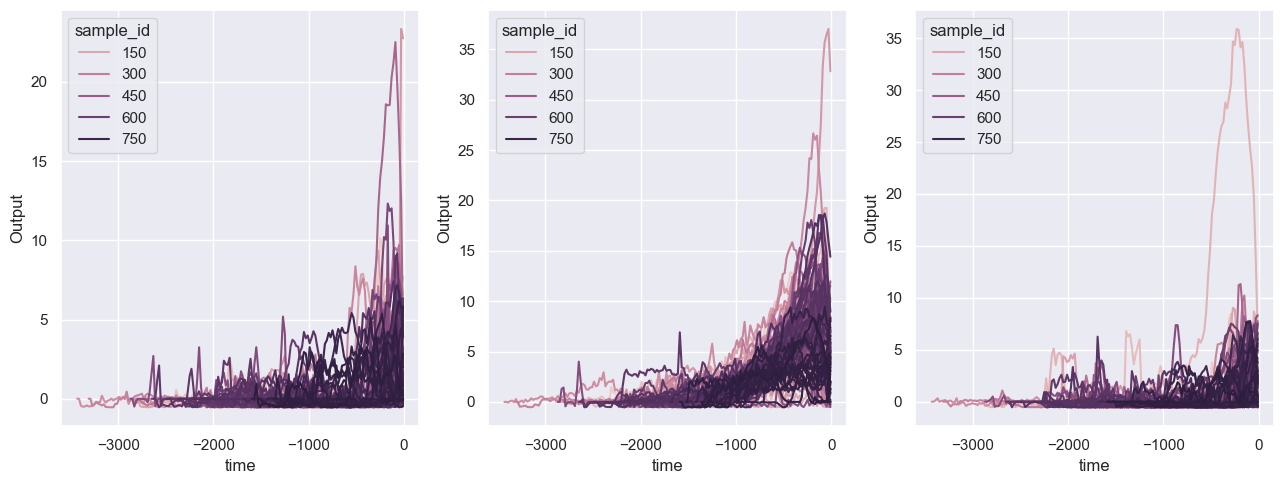

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(13,5))

for k in range(3):

    sns.lineplot(data=df_responses[(df_responses.tile_idx_x==k)
                                & (df_responses.tile_idx_y==1)
                                & (df_responses.coll_type=="cars")],
        x="time", y="Output", hue="sample_id", estimator=None,
        ax=ax[k],
    )
fig.tight_layout()
plt.show()

783


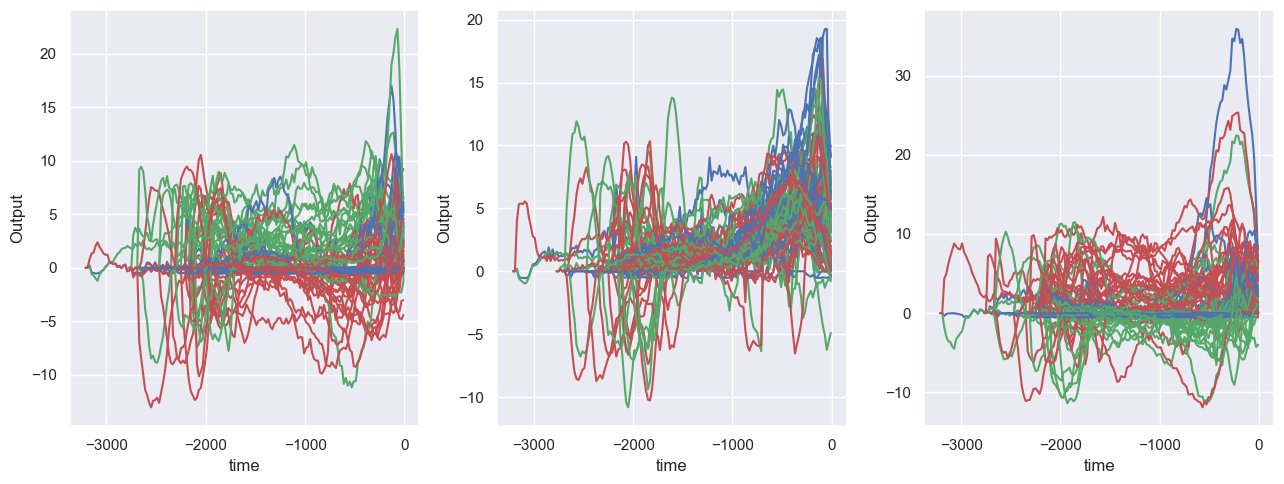

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(13,5))

COLL_TYPE = "cars"

SAMPLE = 34

s_id = int(df_metadata[df_metadata["coll_type"] == COLL_TYPE]["sample_id"].iloc[SAMPLE])

print(s_id)

for k in range(3):

    for s_id in df_metadata[df_metadata["coll_type"] == COLL_TYPE]["sample_id"].astype(int):

        sns.lineplot(data=df_responses[(df_responses.tile_idx_x==k)
                                    & (df_responses.tile_idx_y==1)
                                    & (df_responses.coll_type==COLL_TYPE)
                                    & (df_responses.sample_id==s_id)],
            x="time", y="Output", estimator=None, color="b",
            ax=ax[k],
        )

        #'''
        sns.lineplot(data=df_responses[(df_responses.tile_idx_x==k)
                                    & (df_responses.tile_idx_y==1)
                                    & (df_responses.coll_type==COLL_TYPE)
                                    & (df_responses.sample_id==s_id)],
            x="time", y="r left", estimator=None, color="g",
            ax=ax[k],
        )

        sns.lineplot(data=df_responses[(df_responses.tile_idx_x==k)
                                    & (df_responses.tile_idx_y==1)
                                    & (df_responses.coll_type==COLL_TYPE)
                                    & (df_responses.sample_id==s_id)],
            x="time", y="r right", estimator=None, color="r",
            ax=ax[k],
        )#'''

    #ax[k].set_ylim(top=0.2, bottom=-0.2)
    #ax[k].set_yscale("log")



fig.tight_layout()
plt.show()

,sample_id,coll_type,t_end,vel,diameter,dt
38,167,cars,1869,8.171434,2.595379,10.0


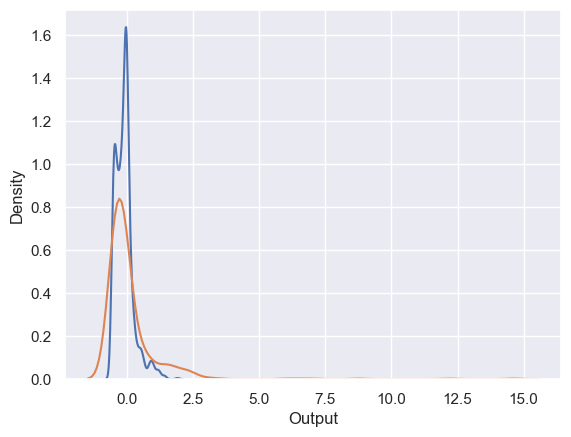

In [108]:
T_MIN = 500.
T_MAX = 600.

df_temp = df_responses[(df_responses.tile_idx_x==k)
                        & (df_responses.tile_idx_y==1)
                        & (df_responses.time <= -T_MIN)
                        & (df_responses.time >= -T_MAX)]

sns.kdeplot(data=df_temp[df_temp.coll_type=="none"], x="Output")

sns.kdeplot(data=df_temp[df_temp.coll_type=="cars"], x="Output")

plt.show()

In [39]:
df_metadata[df_metadata["coll_type"] == "none"].sample_id[0]

'163'

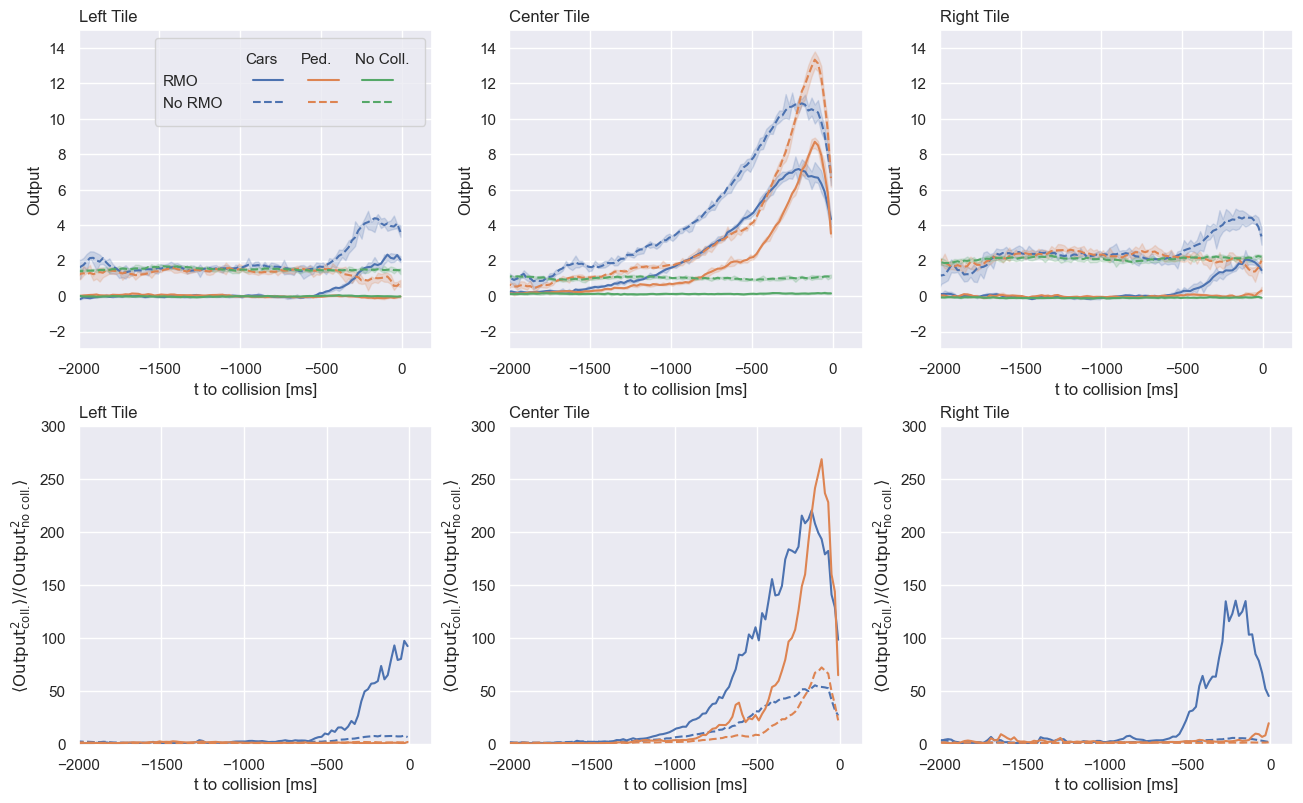

In [110]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(2, 3, figsize=(13, 8))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import matplotlib.patches as m_patches

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]
patches_column4 = [m_patches.Patch(color="none", label="No Coll.")]

for k, _ax in enumerate(ax[0]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    _o_cars = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        label="*",
        legend=False,
    )

    _o_cars_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        linestyle="--",
        label="*",
        legend=False,
    )
    

    _o_pedestrians = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        label="*",
        legend=False,
    )

    _o_pedestrians_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        linestyle="--",
        label="*",
        legend=False,
    )

    

    _o_none = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "none"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        label="*",
        legend=False,
    )

    _o_none_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "none"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        linestyle="--",
        label="*",
        legend=False,
    )

    if k == 0:
        _lines = _ax.get_lines()
        patches_column2.extend([_lines[0], _lines[1]])
        patches_column3.extend([_lines[2], _lines[3]])
        patches_column4.extend([_lines[4], _lines[5]])
    
    _ax.set_ylabel("Output")
    

    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=15., bottom=-3.)

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)
patches.extend(patches_column4)

lg = ax[0,0].legend(
    ncol=4,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8, 10, 11):
        text.set_color("none")

for k, _ax in enumerate(ax[1]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1) & (df_responses_filt["time"] < 0.0)
    ].copy()

    _df_temp["Output Squ"] = _df_temp["Output"] * _df_temp["Output"]
    _df_temp["Output Linear Squ"] = _df_temp["Output Linear"] * _df_temp["Output Linear"]

    _power_resp = _df_temp[["time","coll_type", "Output Squ", "Output Linear Squ"]].groupby(["time","coll_type"]).mean().reset_index()

    _filt_cars = _power_resp["coll_type"]=="cars"
    _filt_pedestrians = _power_resp["coll_type"]=="pedestrians"
    _filt_none = _power_resp["coll_type"]=="none"

    _times_intersect = list((set(_power_resp["time"][_filt_cars]).intersection(set(_power_resp["time"][_filt_pedestrians]))).intersection(set(_power_resp["time"][_filt_none])))
 
    _power_resp = _power_resp[_power_resp["time"].isin(_times_intersect)].copy()

    _filt_cars = _power_resp["coll_type"]=="cars"
    _filt_pedestrians = _power_resp["coll_type"]=="pedestrians"
    _filt_none = _power_resp["coll_type"]=="none"

    _ax.plot(list(_power_resp["time"][_filt_cars]), np.array(list(_power_resp["Output Squ"][_filt_cars]))/np.array(list(_power_resp["Output Squ"][_filt_none])), color=colors[0])
    _ax.plot(list(_power_resp["time"][_filt_cars]), np.array(list(_power_resp["Output Linear Squ"][_filt_cars]))/np.array(list(_power_resp["Output Linear Squ"][_filt_none])), color=colors[0], linestyle="--")

    _ax.plot(list(_power_resp["time"][_filt_pedestrians]), np.array(list(_power_resp["Output Squ"][_filt_pedestrians]))/np.array(list(_power_resp["Output Squ"][_filt_none])), color=colors[1])
    _ax.plot(list(_power_resp["time"][_filt_pedestrians]), np.array(list(_power_resp["Output Linear Squ"][_filt_pedestrians]))/np.array(list(_power_resp["Output Linear Squ"][_filt_none])), color=colors[1], linestyle="--")

    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=300., bottom=-1.0)

    _ax.set_ylabel("$\\langle \\text{Output}_{\\text{coll.}}^2\\rangle / \\langle \\text{Output}_{\\text{no coll.}}^2\\rangle$")

    #_ax.set_yscale("log")

ax[0,0].set_title("Left Tile", loc="left")
ax[0,1].set_title("Center Tile", loc="left")
ax[0,2].set_title("Right Tile", loc="left")

ax[1,0].set_title("Left Tile", loc="left")
ax[1,1].set_title("Center Tile", loc="left")
ax[1,2].set_title("Right Tile", loc="left")

fig.tight_layout(pad=0.5)

fig.savefig("responses_emd_3_tile.png", dpi=400)
fig.savefig("responses_emd_3_tile.pdf")

plt.show()

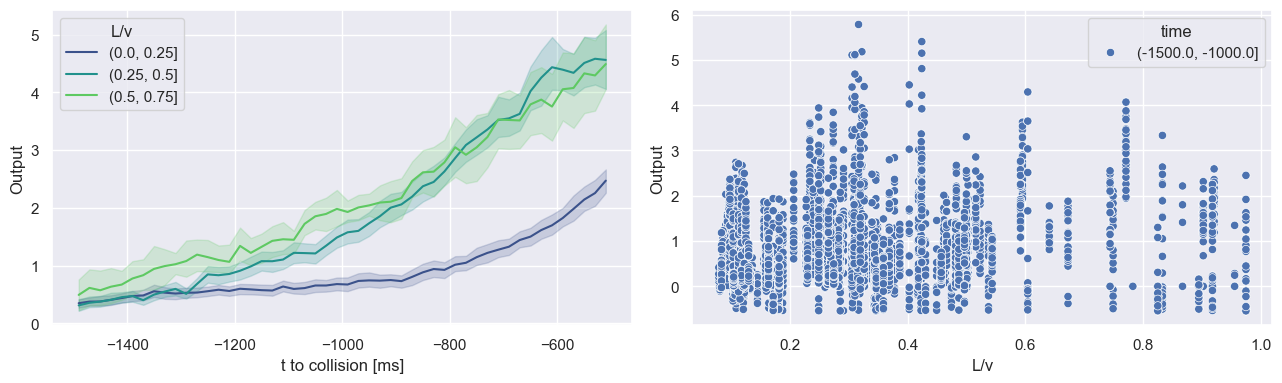

In [111]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["coll_type"] != "none")
]

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -500)
]
sns.lineplot(
    x="time",
    y="Output",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(_df_temp["L/v"], bins=pd.IntervalIndex.from_tuples([(0.,0.25),(0.25,0.5),(0.5,0.75)])),
    palette="viridis",
    ax=ax[0],
    n_boot=200,
)
#ax[0].set_xlim(left=-2000)
ax[0].set_xlabel("t to collision [ms]")

sns.scatterplot(
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x=_df_temp["L/v"],
    y=_df_temp["Output"],
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    #sort=True,
    #orient="x",
    hue=pd.cut(_df_temp.time, bins=pd.IntervalIndex.from_tuples([(-1500.,-1000.)])),
    # palette="viridis",
    ax=ax[1],
    #n_boot=100,
)

fig.tight_layout()

fig.savefig("l_v_responses_emd_3_tile.png", dpi=400)
fig.savefig("l_v_responses_emd_3_tile.pdf")

plt.show()

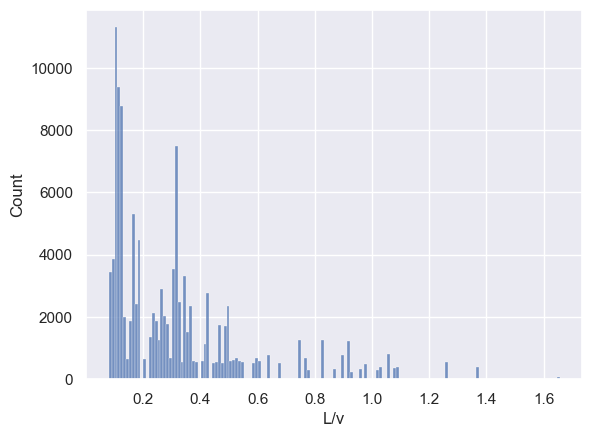

In [112]:
sns.histplot(
    data=df_responses,
    x="L/v"
)

plt.show()

/tmp/ipykernel_120344/2949887946.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(


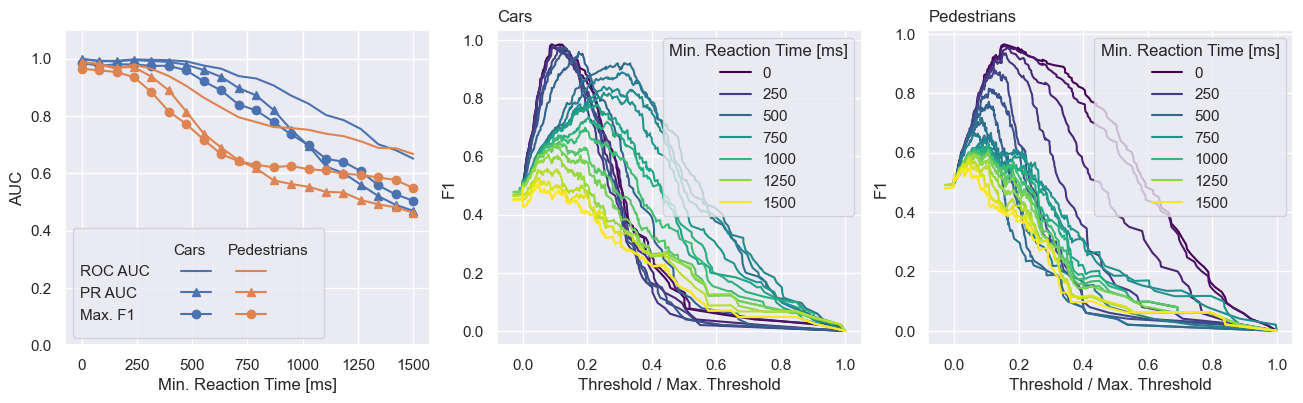

In [113]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

df_emd["positive"] = df_emd["coll_type"] != "none"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"])
    )

    num = 2 * pr_curve_sweep_car[-1][0] * pr_curve_sweep_car[-1][1]
    denom = pr_curve_sweep_car[-1][0] + pr_curve_sweep_car[-1][1]
    max_f1_car.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()

    )
    num = 2 * pr_curve_sweep_pedestrian[-1][0] * pr_curve_sweep_pedestrian[-1][1]
    denom = pr_curve_sweep_pedestrian[-1][0] + pr_curve_sweep_pedestrian[-1][1]
    max_f1_pedestrian.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()
    )

import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
    m_patches.Patch(color="none", label="Max. F1"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "-^", c=colors[0], label="*")
c_max_f1 = ax[0].plot(min_react_time, max_f1_car, "-o", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0], c_max_f1[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "-^", c=colors[1], label="*")
p_max_f1 = ax[0].plot(min_react_time, max_f1_pedestrian, "-o", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0], p_max_f1[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (5, 6, 7, 9, 10, 11):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "coll_type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "cars",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "pedestrians",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd.png", dpi=400)
fig.savefig("roc_pr_emd.pdf")
plt.show()

/tmp/ipykernel_120344/848668776.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(


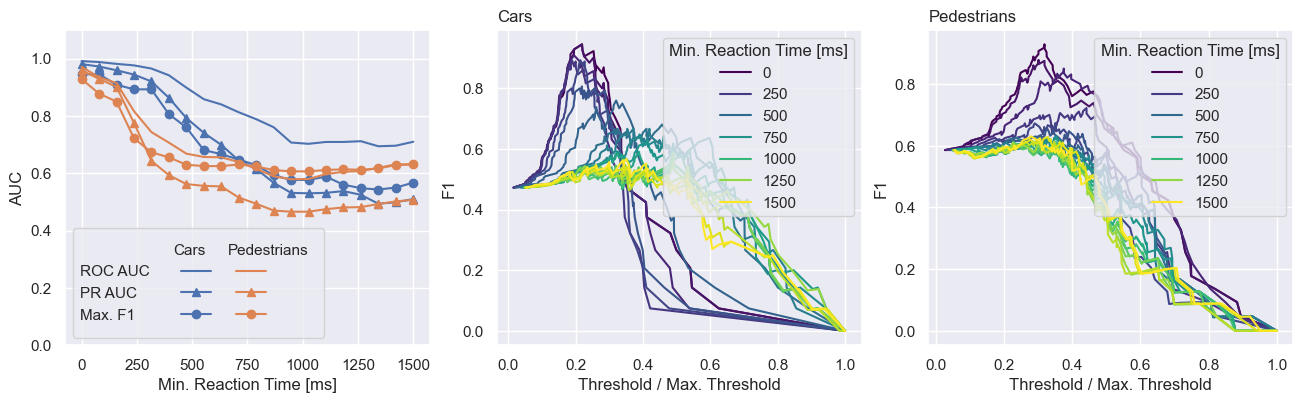

In [77]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

df_emd["positive"] = df_emd["coll_type"] != "none"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"])
    )

    num = 2 * pr_curve_sweep_car[-1][0] * pr_curve_sweep_car[-1][1]
    denom = pr_curve_sweep_car[-1][0] + pr_curve_sweep_car[-1][1]
    max_f1_car.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()

    )
    num = 2 * pr_curve_sweep_pedestrian[-1][0] * pr_curve_sweep_pedestrian[-1][1]
    denom = pr_curve_sweep_pedestrian[-1][0] + pr_curve_sweep_pedestrian[-1][1]
    max_f1_pedestrian.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0)).max()
    )

import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
    m_patches.Patch(color="none", label="Max. F1"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "-^", c=colors[0], label="*")
c_max_f1 = ax[0].plot(min_react_time, max_f1_car, "-o", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0], c_max_f1[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "-^", c=colors[1], label="*")
p_max_f1 = ax[0].plot(min_react_time, max_f1_pedestrian, "-o", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0], p_max_f1[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (5, 6, 7, 9, 10, 11):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "coll_type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "cars",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    num = 2 * pr[0] * pr[1]
    denom = pr[0] + pr[1]
    f1 = np.divide(num, denom, out=np.zeros_like(denom), where=(denom!=0))
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "pedestrians",
                    "F1": f1[1:],
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd_linear.png", dpi=400)
fig.savefig("roc_pr_emd_linear.pdf")
plt.show()

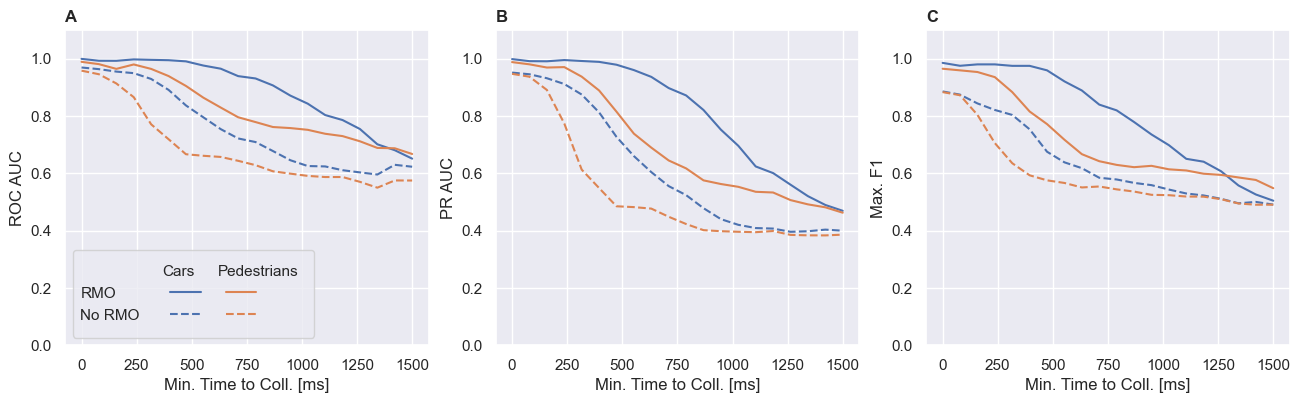

In [120]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    # & (df_responses["tile_idx_x"] == 1)
].copy()

df_emd["positive"] = df_emd["coll_type"] != "none"
# df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

t_max = 2000.0

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        (
            (df_emd["time"] <= -t)
            & (df_emd["time"] > -t_max)
        )
        & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        (
            (df_emd["time"] <= -t)
            & (df_emd["time"] > -t_max)
        )
        & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = _df_car.groupby(["sample_id", "positive"]).max().reset_index()

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(
        roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )
    aupr_car.append(
        average_precision_score(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]
        )
    )
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )

    roc_pedestrian.append(
        roc_auc_score(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )
    aupr_pedestrian.append(
        average_precision_score(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )
    roc_curve_sweep_pedestrian.append(
        roc_curve(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]
        )
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )

    num = 2 * pr_curve_sweep_car[-1][0] * pr_curve_sweep_car[-1][1]
    denom = pr_curve_sweep_car[-1][0] + pr_curve_sweep_car[-1][1]
    max_f1_car.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )
    num = 2 * pr_curve_sweep_pedestrian[-1][0] * pr_curve_sweep_pedestrian[-1][1]
    denom = pr_curve_sweep_pedestrian[-1][0] + pr_curve_sweep_pedestrian[-1][1]
    max_f1_pedestrian.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )


roc_car_linear = []
roc_pedestrian_linear = []
aupr_car_linear = []
aupr_pedestrian_linear = []

roc_curve_sweep_car_linear = []
roc_curve_sweep_pedestrian_linear = []

pr_curve_sweep_car_linear = []
pr_curve_sweep_pedestrian_linear = []

max_f1_car_linear = []
max_f1_pedestrian_linear = []


for t in min_react_time:
    _df_car = df_emd[
        (
            (df_emd["time"] <= -t)
            & (df_emd["time"] > -t_max)
        )
        & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        (
            (df_emd["time"] <= -t)
            & (df_emd["time"] > -t_max)
        )
        & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = _df_car.groupby(["sample_id", "positive"]).max().reset_index()

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car_linear.append(
        roc_auc_score(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]
        )
    )
    aupr_car_linear.append(
        average_precision_score(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]
        )
    )
    roc_curve_sweep_car_linear.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
    )

    roc_pedestrian_linear.append(
        roc_auc_score(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )
    aupr_pedestrian_linear.append(
        average_precision_score(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )
    roc_curve_sweep_pedestrian_linear.append(
        roc_curve(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )

    pr_curve_sweep_car_linear.append(
        precision_recall_curve(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]
        )
    )
    pr_curve_sweep_pedestrian_linear.append(
        precision_recall_curve(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )

    num = 2 * pr_curve_sweep_car_linear[-1][0] * pr_curve_sweep_car_linear[-1][1]
    denom = pr_curve_sweep_car_linear[-1][0] + pr_curve_sweep_car_linear[-1][1]
    max_f1_car_linear.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )
    num = (
        2
        * pr_curve_sweep_pedestrian_linear[-1][0]
        * pr_curve_sweep_pedestrian_linear[-1][1]
    )
    denom = (
        pr_curve_sweep_pedestrian_linear[-1][0]
        + pr_curve_sweep_pedestrian_linear[-1][1]
    )
    max_f1_pedestrian_linear.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )


import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_roc_linear = ax[0].plot(min_react_time, roc_car_linear, "--", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_roc_linear[0]])

p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_roc_linear = ax[0].plot(
    min_react_time, roc_pedestrian_linear, "--", c=colors[1], label="*"
)
patches_column3.extend([p_roc[0], p_roc_linear[0]])

c_aupr = ax[1].plot(min_react_time, aupr_car, "-", c=colors[0], label="*")
c_aupr_linear = ax[1].plot(
    min_react_time, aupr_car_linear, "--", c=colors[0], label="*"
)
p_aupr = ax[1].plot(min_react_time, aupr_pedestrian, "-", c=colors[1], label="*")
p_aupr_linear = ax[1].plot(
    min_react_time, aupr_pedestrian_linear, "--", c=colors[1], label="*"
)

c_max_f1 = ax[2].plot(min_react_time, max_f1_car, "-", c=colors[0], label="*")
c_max_f1_linear = ax[2].plot(
    min_react_time, max_f1_car_linear, "--", c=colors[0], label="*"
)
p_max_f1 = ax[2].plot(min_react_time, max_f1_pedestrian, "-", c=colors[1], label="*")
p_max_f1_linear = ax[2].plot(
    min_react_time, max_f1_pedestrian_linear, "--", c=colors[1], label="*"
)


patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)
ax[1].set_ylim(top=1.1, bottom=0.0)
ax[2].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("ROC AUC")
ax[1].set_ylabel("PR AUC")
ax[2].set_ylabel("Max. F1")

ax[0].set_xlabel("Min. Time to Coll. [ms]")
ax[1].set_xlabel("Min. Time to Coll. [ms]")
ax[2].set_xlabel("Min. Time to Coll. [ms]")

ax[0].set_title("A", loc="left", fontweight="bold")
ax[1].set_title("B", loc="left", fontweight="bold")
ax[2].set_title("C", loc="left", fontweight="bold")

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd.png", dpi=400)
fig.savefig("score_comp_emd.pdf")
plt.show()

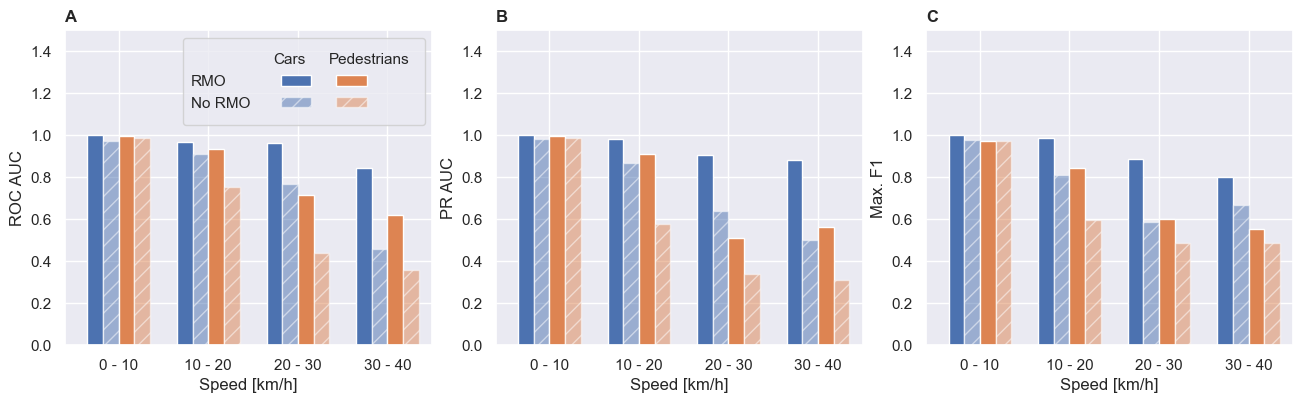

Assumed deceleration: 7.0 m/s^2


In [184]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    # & (df_responses["tile_idx_x"] == 1)
].copy()

A_BREAK = 7.0#0.5 * 9.81

df_emd['min_stop_dist'] = df_emd['vel']**2 / (2*A_BREAK)

df_emd["positive"] = df_emd["coll_type"] != "none"
# df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 5

t_max = 2000.0

vel = np.linspace(0./3.6, 40./3.6, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for i in range(len(vel)-1):
    v0 = vel[i]
    v1 = vel[i+1]

    _df_car = df_emd[
        (
            (df_emd["vel"] < v1)
            & (df_emd["vel"] >= v0)
        )
        & (df_emd['dist'] > df_emd['min_stop_dist'])
        & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        (
            (df_emd["vel"] < v1)
            & (df_emd["vel"] >= v0)
        )
        & (df_emd['dist'] > df_emd['min_stop_dist'])
        & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = _df_car.groupby(["sample_id", "positive"]).max().reset_index()

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(
        roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )
    aupr_car.append(
        average_precision_score(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]
        )
    )
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
    )

    roc_pedestrian.append(
        roc_auc_score(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )
    aupr_pedestrian.append(
        average_precision_score(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )
    roc_curve_sweep_pedestrian.append(
        roc_curve(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"]
        )
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(
            df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"]
        )
    )

    num = 2 * pr_curve_sweep_car[-1][0] * pr_curve_sweep_car[-1][1]
    denom = pr_curve_sweep_car[-1][0] + pr_curve_sweep_car[-1][1]
    max_f1_car.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )
    num = 2 * pr_curve_sweep_pedestrian[-1][0] * pr_curve_sweep_pedestrian[-1][1]
    denom = pr_curve_sweep_pedestrian[-1][0] + pr_curve_sweep_pedestrian[-1][1]
    max_f1_pedestrian.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )


roc_car_linear = []
roc_pedestrian_linear = []
aupr_car_linear = []
aupr_pedestrian_linear = []

roc_curve_sweep_car_linear = []
roc_curve_sweep_pedestrian_linear = []

pr_curve_sweep_car_linear = []
pr_curve_sweep_pedestrian_linear = []

max_f1_car_linear = []
max_f1_pedestrian_linear = []


for i in range(len(vel)-1):
    v0 = vel[i]
    v1 = vel[i+1]

    _df_car = df_emd[
        (
            (df_emd["vel"] < v1)
            & (df_emd["vel"] >= v0)
        )
        & (df_emd['dist'] > df_emd['min_stop_dist'])
        & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        (
            (df_emd["vel"] < v1)
            & (df_emd["vel"] >= v0)
        )
        & (df_emd['dist'] > df_emd['min_stop_dist'])
        & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = _df_car.groupby(["sample_id", "positive"]).max().reset_index()

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car_linear.append(
        roc_auc_score(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]
        )
    )
    aupr_car_linear.append(
        average_precision_score(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]
        )
    )
    roc_curve_sweep_car_linear.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
    )

    roc_pedestrian_linear.append(
        roc_auc_score(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )
    aupr_pedestrian_linear.append(
        average_precision_score(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )
    roc_curve_sweep_pedestrian_linear.append(
        roc_curve(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )

    pr_curve_sweep_car_linear.append(
        precision_recall_curve(
            df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"]
        )
    )
    pr_curve_sweep_pedestrian_linear.append(
        precision_recall_curve(
            df_emd_max_resp_pedestrian["positive"],
            df_emd_max_resp_pedestrian["Output Linear"],
        )
    )

    num = 2 * pr_curve_sweep_car_linear[-1][0] * pr_curve_sweep_car_linear[-1][1]
    denom = pr_curve_sweep_car_linear[-1][0] + pr_curve_sweep_car_linear[-1][1]
    max_f1_car_linear.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )
    num = (
        2
        * pr_curve_sweep_pedestrian_linear[-1][0]
        * pr_curve_sweep_pedestrian_linear[-1][1]
    )
    denom = (
        pr_curve_sweep_pedestrian_linear[-1][0]
        + pr_curve_sweep_pedestrian_linear[-1][1]
    )
    max_f1_pedestrian_linear.append(
        np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
    )


import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

vel_ax = 0.5 * (vel[:-1] + vel[1:]) * 3.6


d_vel =  (vel[1:] -  vel[:-1]) * 3.6
perc_width = 0.7

#c_roc = ax[0].plot(vel_ax, roc_car, "-", c=colors[0], label="*")
c_roc = ax[0].bar(vel_ax - 0.75 * d_vel  * perc_width/2, roc_car, d_vel  * perc_width/4, color=colors[0], label="*")
#c_roc_linear = ax[0].plot(vel_ax, roc_car_linear, "--", c=colors[0], label="*")
c_roc_linear = ax[0].bar(vel_ax - 0.25 * d_vel  * perc_width/2, roc_car_linear, d_vel  * perc_width/4, color=colors[0], hatch="//", alpha=0.5, label="*")

patches_column2.extend([c_roc, c_roc_linear])

#p_roc = ax[0].plot(vel_ax, roc_pedestrian, "-", c=colors[1], label="*")
p_roc = ax[0].bar(vel_ax + 0.25 * d_vel  * perc_width/2, roc_pedestrian, d_vel  * perc_width/4, color=colors[1], label="*")
#p_roc_linear = ax[0].plot(
#    vel_ax, roc_pedestrian_linear, "--", c=colors[1], label="*"
#)
p_roc_linear = ax[0].bar(vel_ax + 0.75 * d_vel  * perc_width/2, roc_pedestrian_linear, d_vel  * perc_width/4, color=colors[1], hatch="//", alpha=0.5, label="*")
patches_column3.extend([p_roc, p_roc_linear])

#c_aupr = ax[1].plot(vel_ax, aupr_car, "-", c=colors[0], label="*")
c_aupr = ax[1].bar(vel_ax - 0.75 * d_vel  * perc_width/2, aupr_car, d_vel  * perc_width/4, color=colors[0], label="*")
#c_aupr_linear = ax[1].plot(
#    vel_ax, aupr_car_linear, "--", c=colors[0], label="*"
#)
c_aupr_linear = ax[1].bar(vel_ax - 0.25 * d_vel  * perc_width/2, aupr_car_linear, d_vel  * perc_width/4, color=colors[0], hatch="//", alpha=0.5, label="*")

#p_aupr = ax[1].plot(vel_ax, aupr_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[1].bar(vel_ax + 0.25 * d_vel  * perc_width/2, aupr_pedestrian, d_vel  * perc_width/4, color=colors[1], label="*")
#p_aupr_linear = ax[1].plot(
#    vel_ax, aupr_pedestrian_linear, "--", c=colors[1], label="*"
#)
p_aupr_linear = ax[1].bar(vel_ax + 0.75 * d_vel  * perc_width/2, aupr_pedestrian_linear, d_vel  * perc_width/4, color=colors[1], hatch="//", alpha=0.5, label="*")

#c_max_f1 = ax[2].plot(vel_ax, max_f1_car, "-", c=colors[0], label="*")
c_max_f1 = ax[2].bar(vel_ax - 0.75 * d_vel  * perc_width/2, max_f1_car, d_vel  * perc_width/4, color=colors[0], label="*")
#c_max_f1_linear = ax[2].plot(
#    vel_ax, max_f1_car_linear, "--", c=colors[0], label="*"
#)
c_max_f1_linear = ax[2].bar(vel_ax - 0.25 * d_vel  * perc_width/2, max_f1_car_linear, d_vel  * perc_width/4, color=colors[0], hatch="//", alpha=0.5, label="*")

#p_max_f1 = ax[2].plot(vel_ax, max_f1_pedestrian, "-", c=colors[1], label="*")
p_max_f1 = ax[2].bar(vel_ax + 0.25 * d_vel  * perc_width/2, max_f1_pedestrian, d_vel  * perc_width/4, color=colors[1], label="*")
#p_max_f1_linear = ax[2].plot(
#    vel_ax, max_f1_pedestrian_linear, "--", c=colors[1], label="*"
#)
p_max_f1_linear = ax[2].bar(vel_ax + 0.75 * d_vel  * perc_width/2, max_f1_pedestrian_linear, d_vel  * perc_width/4, color=colors[1], hatch="//", alpha=0.5, label="*")


patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

xticks = [f'{vel[i]*3.6:.0f} - {vel[i+1]*3.6:.0f}' for i in range(len(vel)-1)]

ax[0].set_xticks(vel_ax, xticks)
ax[1].set_xticks(vel_ax, xticks)
ax[2].set_xticks(vel_ax, xticks)

ax[0].set_ylim(top=1.5, bottom=0.0)
ax[1].set_ylim(top=1.5, bottom=0.0)
ax[2].set_ylim(top=1.5, bottom=0.0)

ax[0].set_xlim(left=-1, right=40)
ax[1].set_xlim(left=-1, right=40)
ax[2].set_xlim(left=-1, right=40)

ax[0].set_ylabel("ROC AUC")
ax[1].set_ylabel("PR AUC")
ax[2].set_ylabel("Max. F1")

ax[0].set_xlabel("Speed [km/h]")
ax[1].set_xlabel("Speed [km/h]")
ax[2].set_xlabel("Speed [km/h]")

ax[0].set_title("A", loc="left", fontweight="bold")
ax[1].set_title("B", loc="left", fontweight="bold")
ax[2].set_title("C", loc="left", fontweight="bold")

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd_speeds.png", dpi=400)
fig.savefig("score_comp_emd_speeds.pdf")
plt.show()

print(f"Assumed deceleration: {A_BREAK} m/s^2")

The above figure shows the performance measures for different driving speeds under the condition that the detection should be before the minimal stopping distance for the given speed.

Under constant deceleration $a$, the minimum stopping distance is $d = v^2 / (2 a)$.

Some references for deceleration values:

+ https://www.sae.org/publications/technical-papers/content/2023-01-0616/
+ https://www.tandfonline.com/doi/pdf/10.1080/16484142.2007.9638118

In [152]:
dir(c_roc)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_callbacks',
 '_label',
 '_remove_method',
 'add_callback',
 'count',
 'datavalues',
 'errorbar',
 'get_children',
 'get_label',
 'index',
 'orientation',
 'patches',
 'pchanged',
 'remove',
 'remove_callback',
 'set_label']

In [151]:
p_aupr

[0.9995757018598401]

In [115]:
th_range = np.linspace(0.0, 2.0, 20)


t_max = 2000.

df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
][["sample_id", "coll_type", "time", "Output", "Output Linear"]].copy()
df_emd["positive"] = (df_emd["coll_type"] != "none")


_df_car = df_emd[
        ((df_emd["time"] <= 0) & (df_emd["time"] > -t_max)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

_df_pedestrian = df_emd[
    ((df_emd["time"] <= 0) & (df_emd["time"] > -t_max)) & (df_emd["coll_type"] != "cars")
].copy()

df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

df_emd_max_resp_pedestrian = (
    _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
)

pr_car = precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output"])
pr_pedestrian = precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output"])

pr_car_linear = precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Linear"])
pr_pedestrian_linear = precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Linear"])

f1_car = 2 * pr_car[0][1:] * pr_car[1][1:] / (pr_car[0][1:] + pr_car[1][1:])
f1_pedestrian = 2 * pr_pedestrian[0][1:] * pr_pedestrian[1][1:] / (pr_pedestrian[0][1:] + pr_pedestrian[1][1:])

f1_car_linear = 2 * pr_car_linear[0][1:] * pr_car_linear[1][1:] / (pr_car_linear[0][1:] + pr_car_linear[1][1:])
f1_pedestrian_linear = 2 * pr_pedestrian_linear[0][1:] * pr_pedestrian_linear[1][1:] / (pr_pedestrian_linear[0][1:] + pr_pedestrian_linear[1][1:])

df_th = pd.DataFrame(columns=["sample_id", "coll_type", "Reaction Time [ms]", "threshold"])
df_th_linear = pd.DataFrame(columns=["sample_id", "coll_type", "Reaction Time [ms]", "threshold"])

th_range = np.linspace(0.0, 0.8, 100)

for th in pr_car[2]:
    _df_filt = df_emd[(df_emd["Output"] >= th) & (df_emd["coll_type"] == "cars")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th = pd.concat(
        [
            df_th,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "cars",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

for th in pr_pedestrian[2]:
    _df_filt = df_emd[(df_emd["Output"] >= th) & (df_emd["coll_type"] == "pedestrians")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th = pd.concat(
        [
            df_th,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "pedestrians",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

for th in pr_car_linear[2]:
    _df_filt = df_emd[(df_emd["Output Linear"] >= th) & (df_emd["coll_type"] == "cars")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th_linear = pd.concat(
        [
            df_th_linear,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "cars",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

for th in pr_pedestrian_linear[2]:
    _df_filt = df_emd[(df_emd["Output Linear"] >= th) & (df_emd["coll_type"] == "pedestrians")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th_linear = pd.concat(
        [
            df_th_linear,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "pedestrians",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

mean_first_detect_car = df_th[df_th["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()
mean_first_detect_pedestrian = df_th[df_th["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()

mean_first_detect_car_linear = df_th_linear[df_th_linear["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()
mean_first_detect_pedestrian_linear = df_th_linear[df_th_linear["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()

sd_first_detect_car = df_th[df_th["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()
sd_first_detect_pedestrian = df_th[df_th["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()

sd_first_detect_car_linear = df_th_linear[df_th_linear["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()
sd_first_detect_pedestrian_linear = df_th_linear[df_th_linear["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()

/tmp/ipykernel_120344/3797955974.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(
/tmp/ipykernel_120344/3797955974.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th_linear = pd.concat(


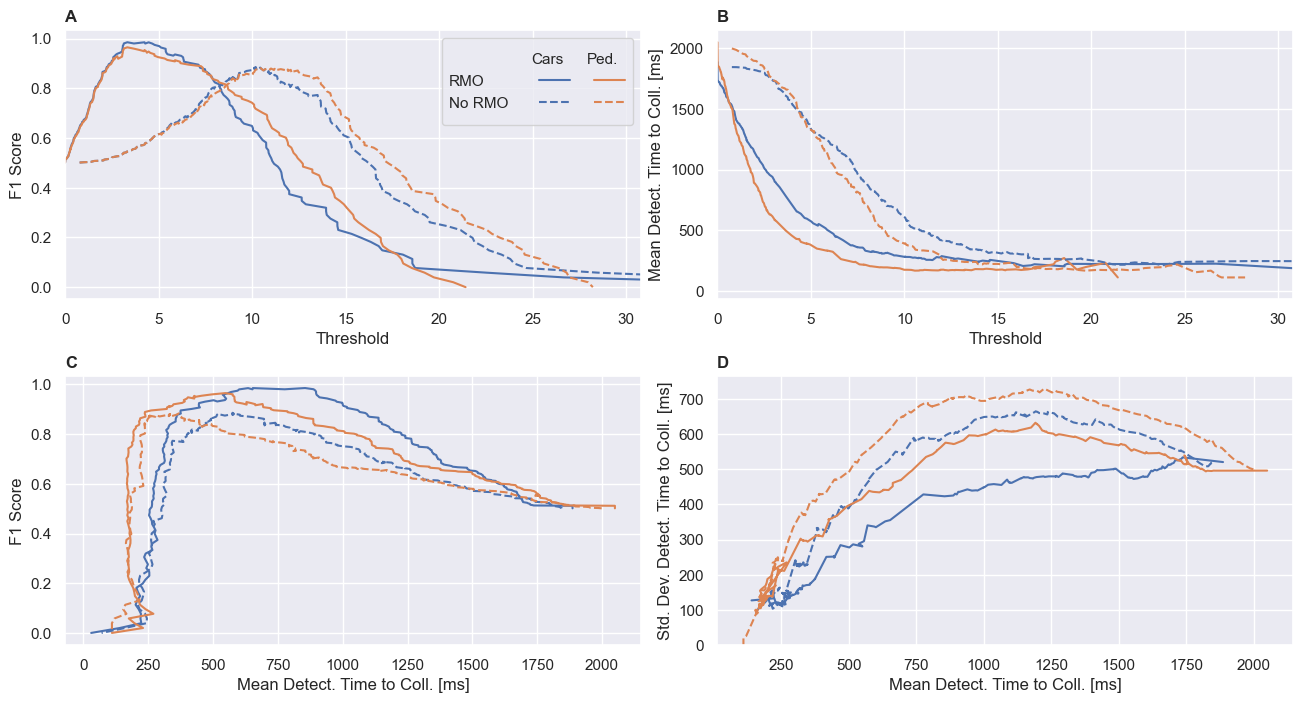

In [116]:
import matplotlib.patches as m_patches

fig, _ax = plt.subplots(2, 2, figsize=(13, 7))
ax = _ax.flatten()

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

c_f1 = ax[0].plot(pr_car[2], f1_car, label="*", color=colors[0])
c_f1_linear = ax[0].plot(
    pr_car_linear[2], f1_car_linear, "--", label="*", color=colors[0]
)
patches_column2.extend([c_f1[0], c_f1_linear[0]])

p_f1 = ax[0].plot(pr_pedestrian[2], f1_pedestrian, label="*", color=colors[1])
p_f1_linear = ax[0].plot(
    pr_pedestrian_linear[2], f1_pedestrian_linear, "--", label="*", color=colors[1]
)
patches_column3.extend([p_f1[0], p_f1_linear[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th[df_th.coll_type == "cars"],
    legend=False,
    ax=ax[1],
    color=colors[0],
    linestyle="-",
)
sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th[df_th.coll_type == "pedestrians"],
    legend=False,
    ax=ax[1],
    color=colors[1],
    linestyle="-",
)

sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th_linear[df_th_linear.coll_type == "cars"],
    legend=False,
    ax=ax[1],
    color=colors[0],
    linestyle="--",
)
sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th_linear[df_th_linear.coll_type == "pedestrians"],
    legend=False,
    ax=ax[1],
    color=colors[1],
    linestyle="--",
)

ax[2].plot(
    mean_first_detect_car["Detect. Time to Coll. [ms]"], f1_car, "-", color=colors[0]
)
ax[2].plot(
    mean_first_detect_car_linear["Detect. Time to Coll. [ms]"],
    f1_car_linear,
    "--",
    color=colors[0],
)

ax[2].plot(
    mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"],
    f1_pedestrian,
    "-",
    color=colors[1],
)
ax[2].plot(
    mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"],
    f1_pedestrian_linear,
    "--",
    color=colors[1],
)

ax[3].plot(
    mean_first_detect_car["Detect. Time to Coll. [ms]"][
        mean_first_detect_car["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_car["Detect. Time to Coll. [ms]"][
        mean_first_detect_car["Detect. Time to Coll. [ms]"] > 100
    ],
    "-",
    color=colors[0],
)
ax[3].plot(
    mean_first_detect_car_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_car_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_car_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_car_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    "--",
    color=colors[0],
)

ax[3].plot(
    mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_pedestrian["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"] > 100
    ],
    "-",
    color=colors[1],
)
ax[3].plot(
    mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    "--",
    color=colors[1],
)

# ax[3].plot(sd_first_detect_pedestrian["Detect. Time to Coll. [ms]"], f1_pedestrian, '-', color=colors[1])
# ax[3].plot(sd_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"], f1_pedestrian_linear, '--', color=colors[1])

ax[0].set_xlim(left=-0.01, right=30.8)
ax[1].set_xlim(left=-0.01, right=30.8)

ax[3].set_ylim(bottom=0.0)

ax[0].set_ylabel("F1 Score")
ax[0].set_xlabel("Threshold")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Mean Detect. Time to Coll. [ms]")

ax[2].set_xlabel("Mean Detect. Time to Coll. [ms]")
ax[2].set_ylabel("F1 Score")

ax[3].set_xlabel("Mean Detect. Time to Coll. [ms]")
ax[3].set_ylabel("Std. Dev. Detect. Time to Coll. [ms]")

ax[0].set_title("A", loc="left", fontweight="bold")
ax[1].set_title("B", loc="left", fontweight="bold")
ax[2].set_title("C", loc="left", fontweight="bold")
ax[3].set_title("D", loc="left", fontweight="bold")

fig.tight_layout(pad=0.5)

fig.savefig("f1_score_detect_time_emd.png", dpi=400)
fig.savefig("f1_score_detect_time_emd.pdf")

plt.show()

/tmp/ipykernel_3860/1709788399.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: u

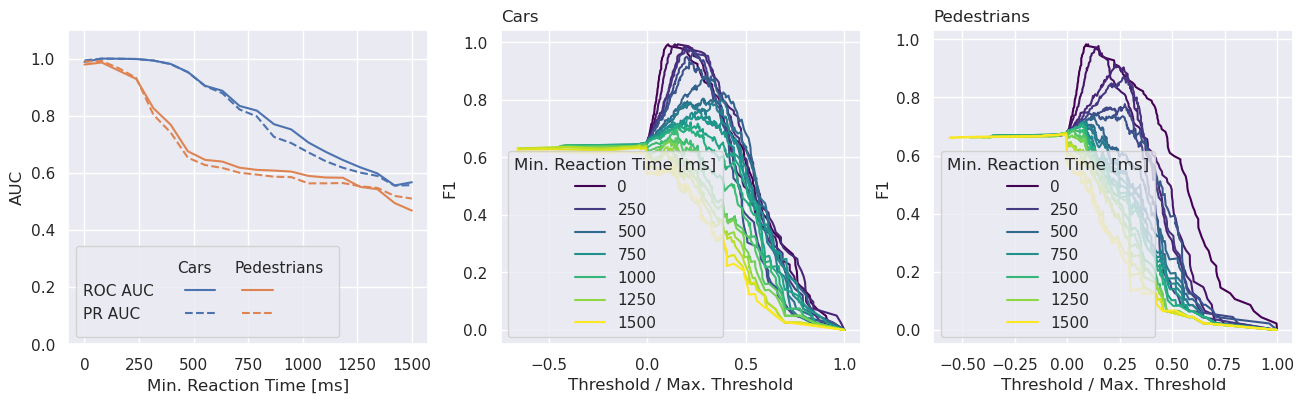

In [21]:
import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "--", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "--", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "coll_type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "cars",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "pedestrians",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd_linear.png", dpi=400)
fig.savefig("roc_pr_emd_linear.pdf")
plt.show()

In [4]:
def gen_evt_hist(evts: np.ndarray, t: float, dt: float, w: int, h: int) -> np.ndarray:
    evts_filt = evts[(evts["t"] >= t) & (evts["t"] < (t + dt))]

    hist = np.histogram2d(
        evts_filt["x"],
        evts_filt["y"],
        bins=[np.arange(w + 1), np.arange(h + 1)],
        weights=evts_filt["p"].astype("i1") * 2 - 1,
    )

    img = np.minimum(1.0, np.maximum(-1.0, hist[0].T))

    return img

In [43]:
data_car_passing = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_car_passing.npz"))

idx_start = 100
idx_end = 250

V_passing = data_car_passing["V"][idx_start:idx_end]
r_left_passing = data_car_passing["r_left"][idx_start:idx_end]
r_right_passing = data_car_passing["r_right"][idx_start:idx_end]
V_linear_passing = 0.5 * (r_left_passing + r_right_passing)

t_ms_passing = np.arange(0, len(V_passing)) * 10.0

events_passing = data_car_passing["events"]

data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start = 75
idx_end = -1

V_turn = data_right_turn["V"][idx_start:idx_end]
r_left_turn = data_right_turn["r_left"][idx_start:idx_end]
r_right_turn = data_right_turn["r_right"][idx_start:idx_end]
V_linear_turn = 0.5 * (r_left_turn + r_right_turn)

t_ms_turn = np.arange(0, len(V_turn)) * 10.0

events_turn = data_right_turn["events"]

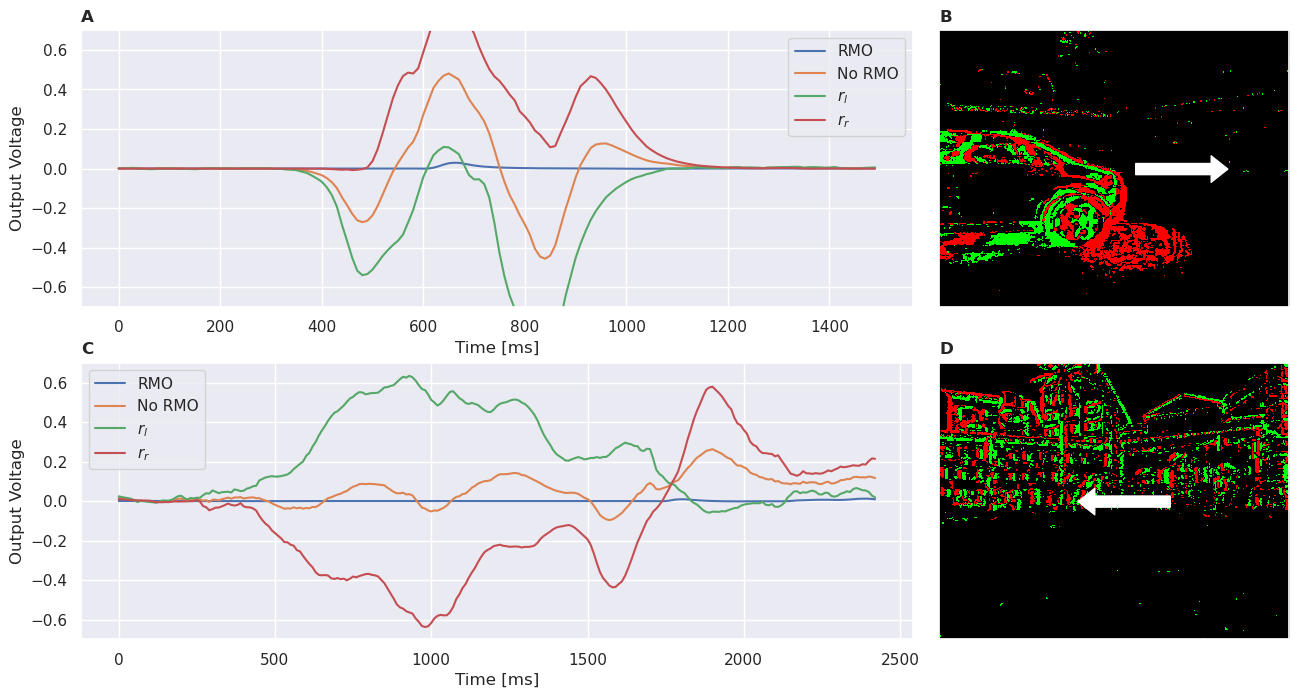

In [65]:
from matplotlib.colors import ListedColormap

cmap_evts = ListedColormap([(1,0,0), "black", (0,1,0)])

fig = plt.figure(figsize=(13, 7))


w_l = 0.64
w_r = 0.4
m_l = 0.065
m_r = 0.66
m_b = 0.08
m_t = 0.5 + m_b - 0.025
h = 0.5 - m_b - 0.025

ax = []
ax.append(fig.add_axes([m_l, m_t, w_l, h]))
ax.append(fig.add_axes([m_r, m_t, w_r, h]))
ax.append(fig.add_axes([m_l, m_b, w_l, h]))
ax.append(fig.add_axes([m_r, m_b, w_r, h]))


#fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].plot(t_ms_passing, V_passing, label="RMO")
ax[0].plot(t_ms_passing, V_linear_passing, label="No RMO")
ax[0].plot(t_ms_passing, r_left_passing, label="$r_l$")
ax[0].plot(t_ms_passing, r_right_passing, label="$r_r$")

ax[0].legend()

ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Output")

ax[0].set_ylim(-0.7, 0.7)

img = gen_evt_hist(events_passing[180000:190000], 0., 20., 304, 240)

ax[1].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[1].grid(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].annotate(None,xy=(250,120),xytext=(170,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

ax[2].plot(t_ms_turn, V_turn, label="RMO")
ax[2].plot(t_ms_turn, V_linear_turn, label="No RMO")
ax[2].plot(t_ms_turn, r_left_turn, label="$r_l$")
ax[2].plot(t_ms_turn, r_right_turn, label="$r_r$")

ax[2].legend()

ax[2].set_xlabel("Time [ms]")
ax[2].set_ylabel("Output")

ax[2].set_ylim(-0.7, 0.7)

img = gen_evt_hist(events_turn[180000:190000], 0., 20., 304, 240)

ax[3].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[3].grid(False)

ax[3].set_xticks([])
ax[3].set_yticks([])

ax[3].annotate(None,xy=(120,120),xytext=(200,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

#fig.tight_layout(pad=0.5)

for i, c in enumerate("ABCD"):
    ax[i].set_title(c, loc="left", fontweight="bold")

fig.savefig("car_passing_turn.png", dpi=400)
fig.savefig("car_passing_turn.pdf")

plt.show()

In [41]:
data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start = 75
idx_end = -1

V = data_right_turn["V"][idx_start:idx_end]
r_left = data_right_turn["r_left"][idx_start:idx_end]
r_right = data_right_turn["r_right"][idx_start:idx_end]
V_linear = 0.5 * (r_left + r_right)

t_ms = np.arange(0, len(V)) * 10.0

events = data_right_turn["events"]

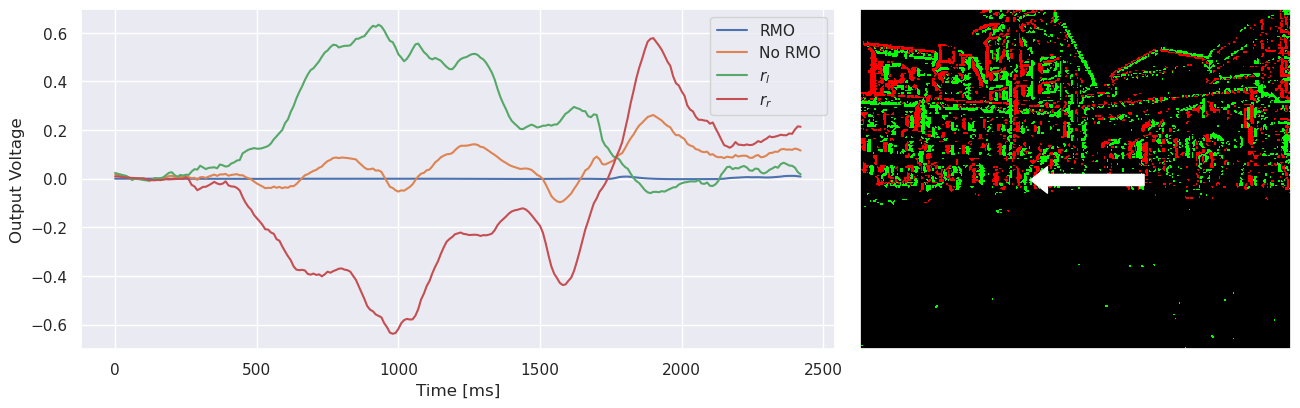

In [42]:
from matplotlib.colors import ListedColormap

cmap_evts = ListedColormap([(1,0,0), "black", (0,1,0)])

fig = plt.figure(figsize=(13, 4))

ax = []
ax.append(fig.add_axes([0.065, 0.14, 0.58, 0.85]))
ax.append(fig.add_axes([0.63, 0.14, 0.4, 0.85]))

#fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].plot(t_ms, V, label="RMO")
ax[0].plot(t_ms, V_linear, label="No RMO")
ax[0].plot(t_ms, r_left, label="$r_l$")
ax[0].plot(t_ms, r_right, label="$r_r$")

ax[0].legend()

ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Output")

img = gen_evt_hist(events[180000:190000], 0., 20., 304, 240)

ax[1].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[1].grid(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].annotate(None,xy=(120,120),xytext=(200,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

#fig.tight_layout(pad=0.5)

fig.savefig("car_right_turn.png", dpi=400)
fig.savefig("car_right_turn.pdf")

plt.show()